In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(); # установка темы графиков

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

См. презентацию `ml_3.pdf`

# Преобразование Бокса-Кокса

Если случайная величина имеет логнормальное распределение, то ее логарифм имеет нормальное распределение.

In [2]:
data_log = pd.Series(np.random.lognormal(0, 1, 1000)) # (mu, sigma, кол-во)

<AxesSubplot:>

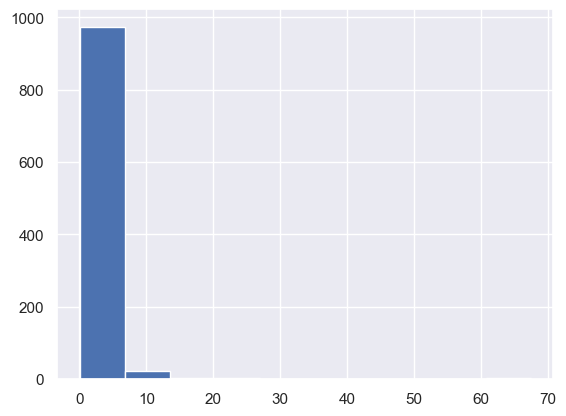

In [3]:
data_log.hist()

<AxesSubplot:>

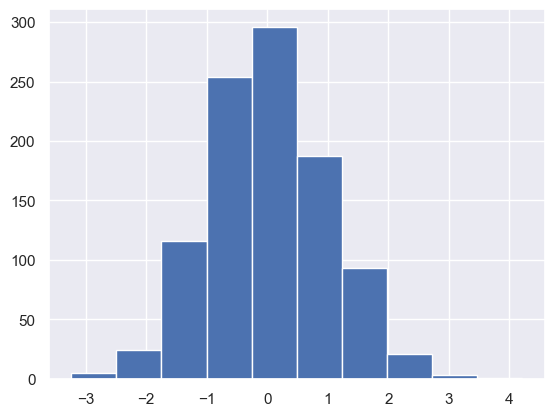

In [4]:
np.log(data_log).hist()

Почему это работает?

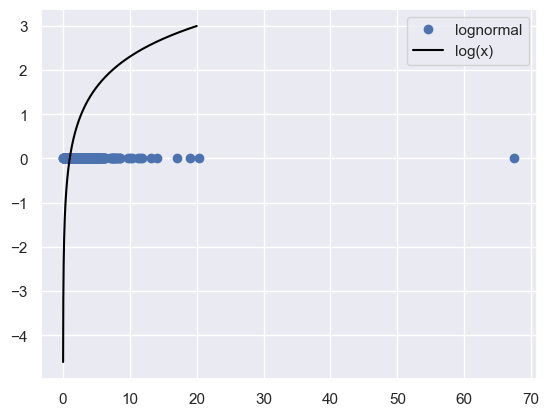

In [5]:
log_x = np.arange(0.01, 20, 0.01)
log_y = np.log(log_x)

x_points = data_log
y_points = np.zeros(1000)

#fig = plt.figure()
plt.plot(x_points, y_points, 'o', label="lognormal")
plt.plot(log_x, log_y, 'black', label='log(x)')

plt.legend()

plt.show()
#fig.show()

Если экспоненциальное распределение?

In [6]:
data_exp = pd.Series(np.random.exponential(size=1000))

<AxesSubplot:>

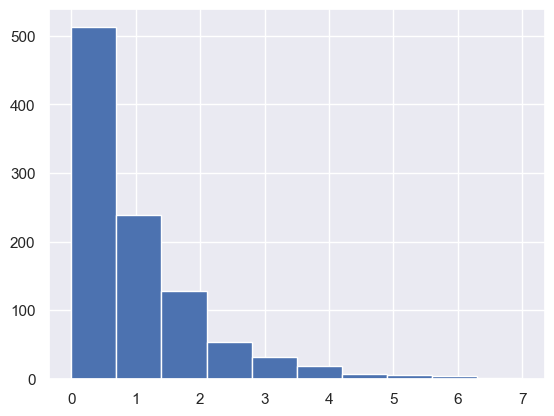

In [7]:
data_exp.hist()

<AxesSubplot:>

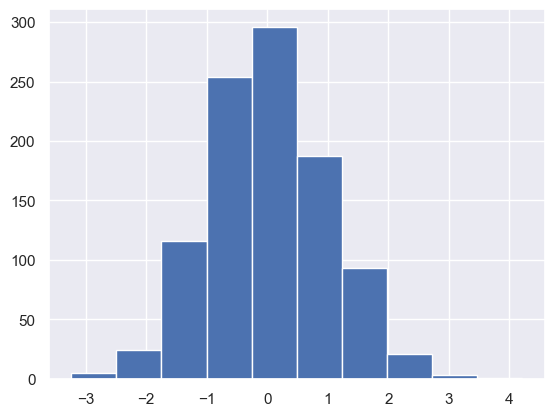

In [8]:
np.log(data_log).hist()

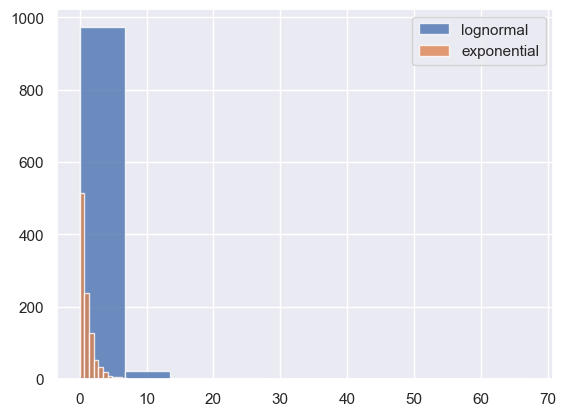

In [9]:
plt.hist(data_log, label='lognormal', alpha=.8)
plt.hist(data_exp, label='exponential', alpha=.8)
plt.legend()

plt.show()

Найдем такое преобразование.

$$\int\frac{1}{x^{1-\lambda}}=\frac{x^\lambda-1}{\lambda}+C,$$
где $\lambda$ - искомый параметр.

$$x^*_i=\begin{cases}
\ln(x), & \lambda=0 \\
\frac{x^\lambda-1}{\lambda}, & \text{в обратном случае.}
\end{cases}$$

In [10]:
from scipy.stats import boxcox
transformed_data, best_lambda = boxcox(data_exp)

<AxesSubplot:>

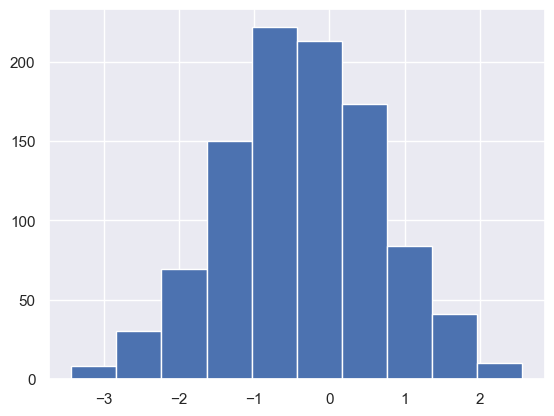

In [11]:
pd.Series(transformed_data).hist()

In [12]:
best_lambda

0.27161744547423194

# Отбор признаков

In [13]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]

In [14]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

## Корреляционный анализ

In [15]:
train_X.columns

Index(['back-suspension', 'battery-capacity', 'charge-time', 'compression',
       'consumption-mixed', 'cylinders-order', 'cylinders-value',
       'engine-feeding', 'engine-start', 'engine-stop', 'engine-type',
       'gear-type', 'luxury', 'max-speed', 'power-electro-kw', 'supply-system',
       'valves', 'valvetrain', 'weight', 'configurations_auto-premiere',
       'configurations_back-wheel-base', 'configurations_front-brake',
       'configurations_safety-rating', 'configurations_seats',
       'configurations_tank-volume', 'supergen_year-stop',
       'models_country-from', 'models_group', 'models_light-and-commercial',
       'models_male'],
      dtype='object')

In [16]:
# Разобъём факторы на группы: порядковые, количественные, категориальные
ordinal = ['back-suspension', 'cylinders-order', 'engine-feeding', 'configurations_seats']
numerical = ['battery-capacity', 'charge-time', 'compression', 'consumption-mixed', 'cylinders-value', 'engine-start', 'engine-stop', 'luxury',
             'max-speed', 'power-electro-kw','valves','weight','configurations_auto-premiere','configurations_back-wheel-base','configurations_tank-volume',
             'supergen_year-stop',]
catigorial = ['engine-type','gear-type', 'supply-system', 'valvetrain', 'configurations_front-brake', 'configurations_safety-rating','models_country-from',
              'models_group', 'models_light-and-commercial','models_male']

<AxesSubplot:xlabel='engine-type', ylabel='Count'>

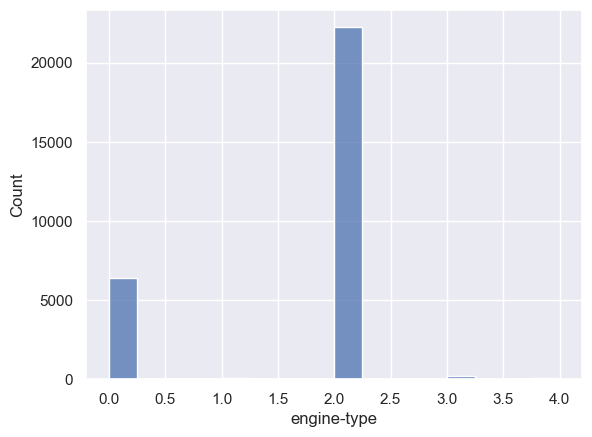

In [17]:
sns.histplot(data=train_X, x='engine-type')

In [18]:
#sns.pairplot(train_X[numerical]);

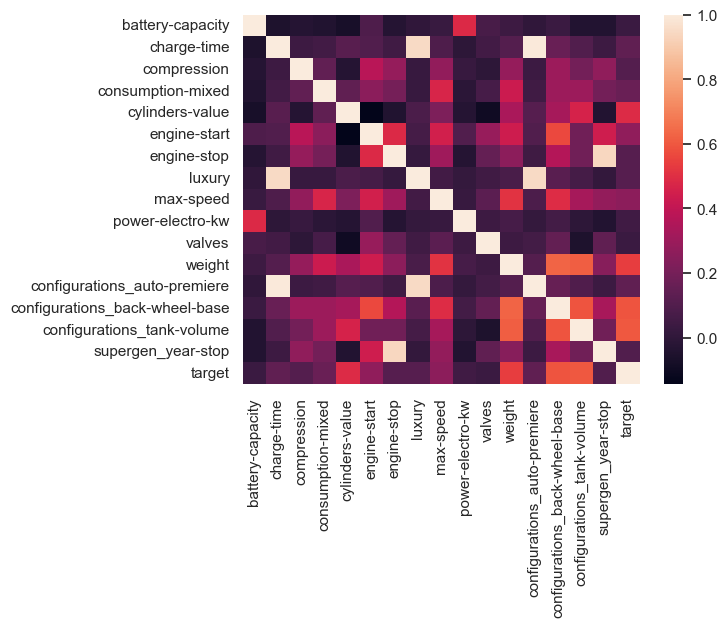

In [19]:
train = train_X.copy()
train['target'] = train_y
sns.heatmap(train[numerical + ['target']].corr(method='spearman'));

In [20]:
from scipy.stats import pearsonr, spearmanr

r = pearsonr(train['configurations_auto-premiere'], train['target'])
print('Pearson correlation:', r[0], 'p-value:', r[1])

Pearson correlation: 0.11003752360955588 p-value: 9.725646829179841e-79


In [21]:
r = pearsonr(train['battery-capacity'], train['target'])
print('Pearson correlation:', r[0], 'p-value:', r[1])

Pearson correlation: 0.02366518366709964 p-value: 5.610547363570721e-05


## F-test

In [22]:
from sklearn.feature_selection import f_regression, SelectKBest

In [23]:
f_statistic, p_values = f_regression(train_X, train_y)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
train_X

,back-suspension,battery-capacity,charge-time,compression,consumption-mixed,cylinders-order,cylinders-value,engine-feeding,engine-start,engine-stop,...,configurations_back-wheel-base,configurations_front-brake,configurations_safety-rating,configurations_seats,configurations_tank-volume,supergen_year-stop,models_country-from,models_group,models_light-and-commercial,models_male
22607,3,-1.0,11636,9.5,-1.0,0,4,4,1997,2000,...,1415.0,4,2,13,50.0,2000.0,16,3,0,1
36531,8,-1.0,31764,9.0,-1.0,0,4,0,1990,1993,...,1310.0,1,2,13,48.0,1996.0,23,3,0,0
24048,8,-1.0,2773,8.8,6.8,0,4,4,2009,2012,...,1558.0,4,1,13,56.0,2012.0,10,3,0,1
34819,3,-1.0,52039,14.0,5.3,0,4,5,2015,2017,...,1590.0,4,2,13,56.0,2017.0,16,3,0,0
1328,3,-1.0,20689,18.0,7.5,0,5,5,2004,2005,...,1560.0,4,2,13,70.0,2009.0,28,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,6,-1.0,42729,16.5,4.7,0,4,5,2017,0,...,1630.0,4,2,13,68.0,-1.0,10,3,0,1
11284,0,-1.0,46093,8.1,-1.0,3,7,0,1987,1990,...,1486.0,4,2,13,82.0,1996.0,34,3,0,1
38158,3,-1.0,48819,10.0,7.6,0,4,2,2018,0,...,1636.0,4,2,13,62.0,-1.0,26,3,0,1
860,10,-1.0,9346,22.4,-1.0,0,4,6,1992,1995,...,1460.0,1,2,13,50.0,1995.0,16,3,0,1


In [25]:
p_values

array([4.14261514e-178, 5.61054736e-005, 2.22583374e-084, 4.29215233e-006,
       5.19880608e-097, 0.00000000e+000, 0.00000000e+000, 3.00761649e-002,
       1.23407205e-153, 1.91780781e-122, 1.08128701e-102, 5.89170255e-038,
       1.18423856e-051, 6.73034264e-090, 6.04804785e-008, 3.29025321e-015,
       3.33873440e-033, 1.45689423e-002, 0.00000000e+000, 9.72564683e-079,
       6.46321123e-022, 5.15233301e-231, 8.63015515e-002, 0.00000000e+000,
       0.00000000e+000, 1.90641086e-122, 7.01981268e-140, 5.09638729e-005,
       4.56879391e-064, 3.51507643e-001])

In [26]:
# отбираем 20 лучших признаков
sekector = SelectKBest(f_regression, k=20)
sekector.fit_transform(train_X, train_y)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 3.0000e+00,  1.1636e+04, -1.0000e+00, ...,  2.0000e+03,
         1.6000e+01,  0.0000e+00],
       [ 8.0000e+00,  3.1764e+04, -1.0000e+00, ...,  1.9960e+03,
         2.3000e+01,  0.0000e+00],
       [ 8.0000e+00,  2.7730e+03,  6.8000e+00, ...,  2.0120e+03,
         1.0000e+01,  0.0000e+00],
       ...,
       [ 3.0000e+00,  4.8819e+04,  7.6000e+00, ..., -1.0000e+00,
         2.6000e+01,  0.0000e+00],
       [ 1.0000e+01,  9.3460e+03, -1.0000e+00, ...,  1.9950e+03,
         1.6000e+01,  0.0000e+00],
       [ 3.0000e+00,  4.3309e+04, -1.0000e+00, ...,  2.0070e+03,
         3.5000e+01,  0.0000e+00]])

In [27]:
sekector.get_feature_names_out()

array(['back-suspension', 'charge-time', 'consumption-mixed',
       'cylinders-order', 'cylinders-value', 'engine-start',
       'engine-stop', 'engine-type', 'gear-type', 'luxury', 'max-speed',
       'valves', 'weight', 'configurations_auto-premiere',
       'configurations_front-brake', 'configurations_seats',
       'configurations_tank-volume', 'supergen_year-stop',
       'models_country-from', 'models_light-and-commercial'], dtype=object)

## Значения Шепли

In [28]:
#!pip install shap

In [29]:
import shap

In [30]:
reg = LinearRegression().fit(train_X, train_y)

In [31]:
explainer = shap.Explainer(reg, train_X)
shap_values = explainer(test_X)

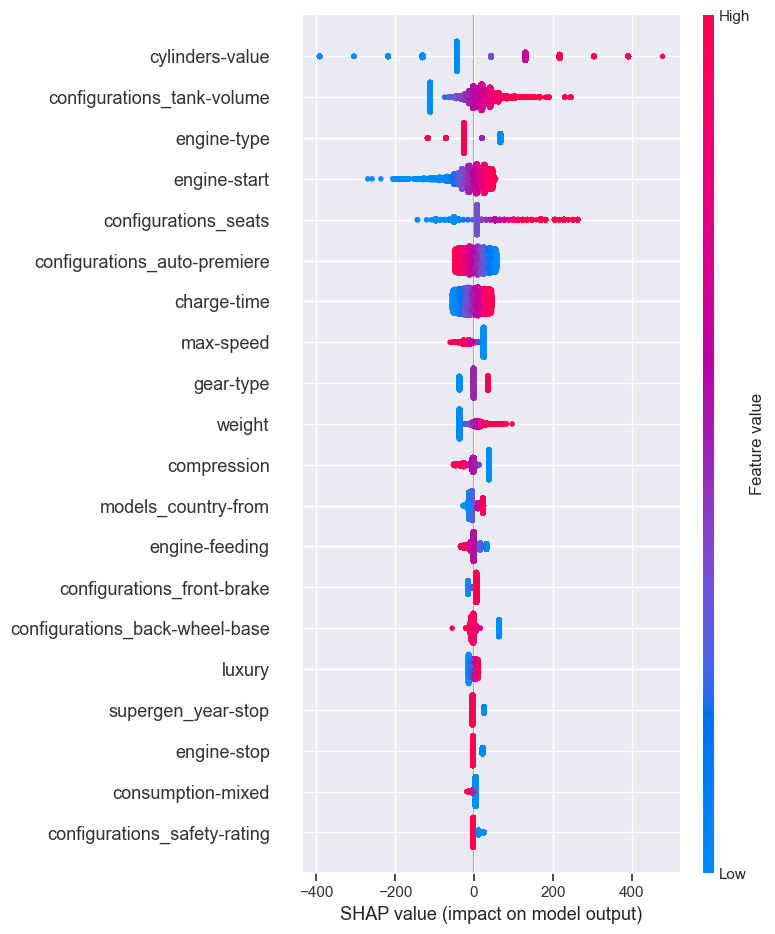

In [32]:
shap.summary_plot(shap_values, test_X)

Для признака cylinders-value наблюдается положительная статистическая зависимость от целевой переменной. Сравните Ваш результат с результатом работы библиотеки shap.

In [33]:
train_cut_X = train_X[train_X.columns[:5]]
test_cut_X = test_X[train_X.columns[:5]]

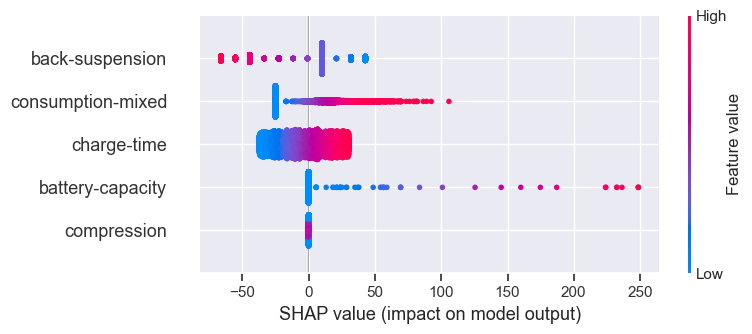

In [34]:
reg = LinearRegression().fit(train_cut_X, train_y)

explainer = shap.Explainer(reg, train_cut_X)
shap_values = explainer(test_cut_X)

shap.summary_plot(shap_values, test_cut_X)

### Задание

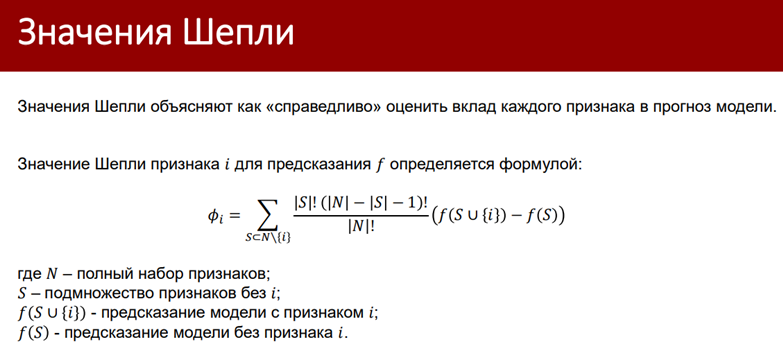

|..| - это мощность (кол-во элементов(признаков))

Для сокращенных данных (train_cut_X и test_cut_X) реализовать метод отбора важности признаков по Шепли.

In [35]:
import math

In [36]:
N = train_cut_X.columns
N

Index(['back-suspension', 'battery-capacity', 'charge-time', 'compression',
       'consumption-mixed'],
      dtype='object')

In [37]:
# функция для формирования подмноджеств
from itertools import chain, combinations

def S(iterable):
    "S([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    k = list(iterable)
    return chain.from_iterable(combinations(k, r) for r in range(1, len(k)+1))
    # в range начинаем с 1, чтобы пустое подмножество не учитывать

In [38]:
from sklearn.metrics import  r2_score

In [39]:
# создадим модель линейной регрессии
model = LinearRegression()

# обучим нашу модель
model.fit(train_X, train_y)

model.predict(train_X)

array([[2525.31491748],
       [2568.95459173],
       [2596.62997475],
       ...,
       [2685.44228379],
       [2546.02154779],
       [2930.16125542]])

In [40]:
model.score(train_X, train_y)

0.45548738550350776

In [41]:
r2_score(model.predict(train_X), train_y)

-0.19545048189347414

In [42]:
r2_score(train_y, model.predict(train_X))

0.45548738550350776

In [43]:
shap_value = []
# для каждого фактора:
for i in N:
    sum_ = 0
    N_off_i = list(N)
    N_off_i.pop(N_off_i.index(i)) # N_off_i - набор факторов без фактора i
    # для каждого подмножества среди всех подмножеств без фактора i:
    for s in S(N_off_i):
        # считаем дробь
        n = (math.factorial(len(s)) * math.factorial(len(N)-len(s)-1)) / math.factorial(len(N))
        
        # обучаем модель с признаками из подмножества s и  с признаком i
        f_s_i = LinearRegression().fit(train_cut_X[list(s)+[i]], train_y)
        # обучаем модель с признаками из подмножества s, но без признака i
        f_s = LinearRegression().fit(train_cut_X[list(s)], train_y)
        
        # с помощью r2_score рассчитываем R2 по предсказанным значениям 'y' тестовой выборки
        # (! модель предсказания f_s_i обучена по данным train !) и фактическим значениям 'y' тестовой выборки
        r2_i = r2_score(test_y, f_s_i.predict(test_cut_X[list(s)+[i]]))
        # с помощью r2_score рассчитываем R2 по предсказанным значениям 'y' тестовой выборки
        # (! модель предсказания f_s обучена по данным train !) и фактическим значениям 'y' тестовой выборки
        r2 = r2_score(test_y, f_s.predict(test_cut_X[list(s)]))
        
        # находим сумму
        sum_ += n * (r2_i - r2)
        
    shap_value.append(sum_)

In [44]:
data = pd.DataFrame(data={'factors': N, 'shap_value': shap_value})
# отсортируем датафрейм по убыванию
data.sort_values(by='shap_value', ascending=False).reset_index(drop=True)

,factors,shap_value
0,back-suspension,1.321851e-02
1,consumption-mixed,7.639649e-03
2,charge-time,5.856657e-03
3,battery-capacity,9.494177e-04
4,compression,3.107232e-07


## Пермутационная важность

In [45]:
#!pip install eli5

In [46]:
import eli5
from eli5.sklearn import PermutationImportance

In [47]:
reg = LinearRegression().fit(train_X, train_y)

In [48]:
perm = PermutationImportance(reg, random_state=42).fit(test_X, test_y)

In [49]:
eli5.show_weights(perm, feature_names=list(test_X.columns))

Weight,Feature
0.3617 ± 0.0044,cylinders-value
0.1035 ± 0.0039,configurations_tank-volume
0.0959 ± 0.0066,configurations_seats
0.0498 ± 0.0020,engine-type
0.0466 ± 0.0009,engine-start
0.0291 ± 0.0012,configurations_auto-premiere
0.0287 ± 0.0023,charge-time
0.0196 ± 0.0027,compression
0.0193 ± 0.0019,gear-type
0.0165 ± 0.0020,weight


### Задание

Самостоятельно реализовать алгоритм отбора признаков на основе пермутационной важности. Построить гистограмму полученных значений.

In [50]:
# создаём модель регрессии на основе набора train
reg = LinearRegression().fit(train_X, train_y)

In [51]:
# находим R2 тестовых наборов по модели, созданной на основе набора train
r2 = reg.score(test_X, test_y)

In [52]:
data = pd.DataFrame(data = test_X.columns, columns=['factors'])

In [53]:
weight = []
for column in test_X.columns:
    test_X_temporary = test_X.copy()
    # перемешиваем значения столбца column в случайном порядке .sample(frac=1)
    # (frac=1 означает, что доля выборки (sample) среди всех значений в столбце column равна 1, т.е. все значения перемешиваем)
    test_X_temporary[column] = test_X_temporary[column].sample(frac=1).tolist()
    # находим R2 тестовых наборов (где теперь тестовые значения факторов в столбце column перемешаны) по модели,
    # созданной на основе набора train
    r2_new = reg.score(test_X_temporary, test_y)
    # находим разницу между r2 и r2_new
    weig = round(r2 - r2_new, 4)
    
    weight.append(weig)

In [54]:
data['weight'] = weight

In [55]:
# сортируем датафрейм по убыванию качества прогноза
data.sort_values(by='weight', ascending=False)

,factors,weight
6,cylinders-value,0.3642
24,configurations_tank-volume,0.1034
23,configurations_seats,0.0952
10,engine-type,0.0510
8,engine-start,0.0499
19,configurations_auto-premiere,0.0282
2,charge-time,0.0281
3,compression,0.0187
11,gear-type,0.0184
18,weight,0.0161


Порядок факторов по качеству прогноза совпал с результатом использования библиотеки shap

<AxesSubplot:>

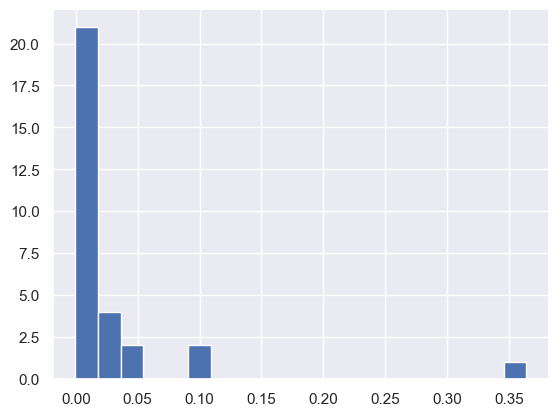

In [56]:
data['weight'].hist(bins=20)

# Домашнее задание

Сгенерировать полиномиальные признаки для рассматриваегомого сегодня набора данных. Попробовать отобрать признаки различными методами (можно теми, что не рассматривали). Получить максимальное качество на тестовых данных. Проинтерпретировать результаты.

In [76]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]

In [77]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

В данных очень много значений -1. Видимо, так заполнены пропуски. Заменим эти -1 на медианные значения

In [78]:
def replace_na(df_train, df_test, col):
    med = train_X[train_X[col] != -1][col].median()
    df_train[col] = df_train[col].replace(-1, med)
    df_test[col] = df_test[col].replace(-1, med) # заполняем той же медианой, что и на df_train !
                                                 # (мы всегда обучаемся, находим всё по train,
                                                 # и с помощью треиновых показателей заполняем test)
    return df_train, df_test

In [79]:
for col in test_X.columns:
    train_X, test_X = replace_na(train_X, test_X, col)

In [80]:
# Разобъём факторы на группы: порядковые, количественные, категориальные
ordinal = ['back-suspension', 'cylinders-order', 'engine-feeding', 'configurations_seats','models_male']
numerical = ['battery-capacity', 'charge-time', 'compression', 'consumption-mixed', 'cylinders-value', 'engine-start', 'engine-stop', 'luxury',
             'max-speed', 'power-electro-kw','valves','weight','configurations_auto-premiere','configurations_back-wheel-base','configurations_tank-volume',
             'supergen_year-stop',]
catigorial = ['engine-type','gear-type', 'supply-system', 'valvetrain', 'configurations_front-brake', 'configurations_safety-rating','models_country-from',
              'models_group', 'models_light-and-commercial']

In [81]:
# Закодируем категориальные признаки
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(train_X[catigorial])

feature_name = enc.get_feature_names_out(catigorial)
train_X[feature_name] = enc.transform(train_X[catigorial]).toarray()
train_X = train_X.drop(catigorial, axis=1)

test_X[feature_name] = enc.transform(test_X[catigorial]).toarray()
test_X = test_X.drop(catigorial, axis=1)

In [82]:
train_X.columns

Index(['back-suspension', 'battery-capacity', 'charge-time', 'compression',
       'consumption-mixed', 'cylinders-order', 'cylinders-value',
       'engine-feeding', 'engine-start', 'engine-stop', 'luxury', 'max-speed',
       'power-electro-kw', 'valves', 'weight', 'configurations_auto-premiere',
       'configurations_back-wheel-base', 'configurations_seats',
       'configurations_tank-volume', 'supergen_year-stop', 'models_male',
       'engine-type_0', 'engine-type_1', 'engine-type_2', 'engine-type_3',
       'engine-type_4', 'gear-type_0', 'gear-type_1', 'gear-type_2',
       'supply-system_0', 'supply-system_1', 'supply-system_2',
       'supply-system_3', 'supply-system_4', 'valvetrain_0', 'valvetrain_1',
       'valvetrain_2', 'valvetrain_3', 'valvetrain_4',
       'configurations_front-brake_0', 'configurations_front-brake_1',
       'configurations_front-brake_2', 'configurations_front-brake_3',
       'configurations_front-brake_4', 'configurations_safety-rating_0',
      

<b>Создадим полиномиальные признаки

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [84]:
poly = PolynomialFeatures(2)
train_X = pd.DataFrame(poly.fit_transform(train_X), columns=poly.get_feature_names_out())
test_X = pd.DataFrame(poly.transform(test_X), columns=poly.get_feature_names_out()) # тут в принципе можно и fit_transform
                                                                # ,т.к. и в train, и в test признаки одинаково преобразуются

Про `fit, transform, fit_transform`: https://www.geeksforgeeks.org/what-is-the-difference-between-transform-and-fit_transform-in-sklearn-python/

### Проведём отбор признаков

**1 способ: F-тест**

In [85]:
f_statistic, p_values = f_regression(train_X, train_y)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:358: RuntimeWarning: invalid value encountered in true_divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


In [86]:
p_values

array([            nan, 4.14261514e-178, 6.08325735e-004, ...,
       4.56879391e-064,             nan, 4.56879391e-064])

In [87]:
# отбираем 500 лучших признаков
sekector = SelectKBest(f_regression, k=500)
train_X_f_reg = pd.DataFrame(sekector.fit_transform(train_X, train_y), columns = sekector.get_feature_names_out())
test_X_f_reg = pd.DataFrame(sekector.transform(test_X), columns = sekector.get_feature_names_out())

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:358: RuntimeWarning: invalid value encountered in true_divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


<b>Оценка

In [88]:
reg = LinearRegression().fit(train_X_f_reg, train_y)

In [89]:
reg.score(train_X_f_reg, train_y)

0.7099586076566972

In [90]:
#Находим значение R2 по тестовым данным по модели reg (которая обучена на треиновом наборе)!
reg.score(test_X_f_reg, test_y)

0.7126643927200795

In [91]:
mean_squared_error(reg.predict(train_X_f_reg), train_y)

15896.26621050993

In [92]:
mean_squared_error(reg.predict(test_X_f_reg), test_y)

16648.95610493447

**2 способ: Значения Шепли**

In [230]:
explainer = shap.Explainer(reg, train_X)
shap_values = explainer(test_X)

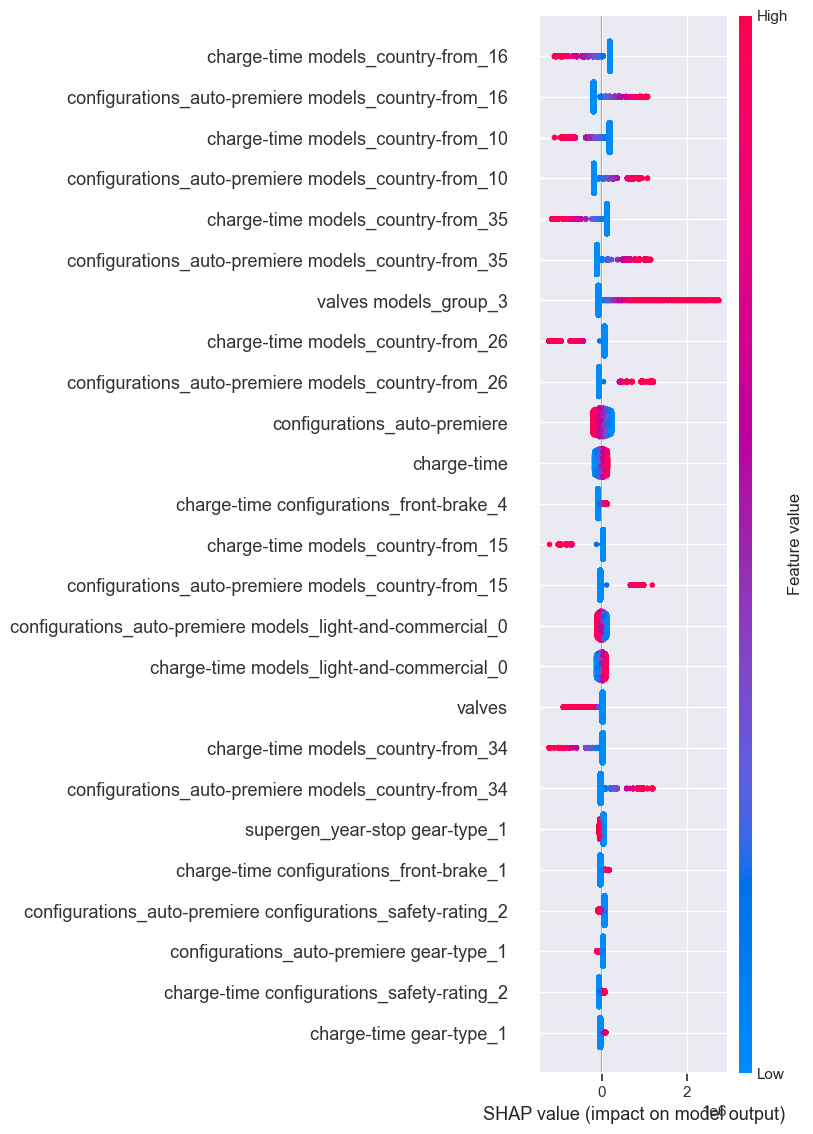

In [231]:
shap.summary_plot(shap_values, test_X, max_display=25)
# max_display=25 - чтобы на рисунке первые 25 были показаны

**3 способ: Пермутационная важность**

НЕ ХВАТАЕТ МОЩНОСТИ КОМПЬЮТЕРА, ЧТОБЫ ВЫЧИСЛИТЬ, СЛИШКОМ МНОГО ФАКТОРОВ

In [111]:
#reg = LinearRegression().fit(train_X, train_y)

In [136]:
# НЕ ХВАТАЕТ МОЩНОСТИ КОМПЬЮТЕРА, ЧТОБЫ ВЫЧИСЛИТЬ, СЛИШКОМ МНОГО ФАКТОРОВ

#perm = PermutationImportance(reg, random_state=42).fit(test_X, test_y)

In [137]:
#eli5.show_weights(perm, feature_names=list(test_X.columns))

In [139]:
# реализовать метод отбора важности признаков по Шепли (вычисляем значения по формуле Шепли)

In [108]:
#reg = LinearRegression().fit(train_X, train_y)

In [133]:
#r2 = reg.score(test_X, test_y)

In [131]:
#data = pd.DataFrame(data = test_X.columns, columns=['factors'])

In [138]:
# НЕ ХВАТАЕТ МОЩНОСТИ КОМПЬЮТЕРА, ЧТОБЫ ВЫЧИСЛИТ, СЛИШКОМ МНОГО ФАКТОРОВ

#weight = []
#for column in test_X.columns:
#    test_X_temporary = test_X.copy()
#    test_X_temporary[column] = test_X_temporary[column].sample(frac=1).tolist()
#    r2_new = reg.score(test_X_temporary, test_y)
#    weig = round(r2 - r2_new, 4)
#    
#    weight.append(weig)

In [49]:
#data['weight'] = weight

In [140]:
#data.sort_values(by='weight', ascending=False)

In [141]:
#data['weight'].hist(bins=20)

**4 способ: Ridge и Lasso регуляризация**

In [94]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

 Ridge

In [95]:

# создадим модель линейной регрессии
model = Ridge()

# обучим нашу модель
model.fit(train_X, train_y)

print(model.coef_, model.intercept_)

[[  0.         -79.03334248  -1.89453365 ...  -0.18654165   0.
    0.18654165]] [503618.58596334]


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.12948e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [96]:
# делаем прогнозы
predictions = model.predict(test_X)
predictions

array([[2527.88877699],
       [2831.67642415],
       [2558.59838463],
       ...,
       [2326.10739335],
       [2615.3647016 ],
       [2533.02395458]])

In [97]:
model.score(train_X, train_y)

0.7514818623140804

In [98]:
#Находим значение R2 по тестовым данным по модели reg (которая обучена на треиновом наборе)!
model.score(test_X, test_y)

-2.2436185054829076

По тестовому набору данных R2 получился отрицательным, значит эта модель плохая

 Lasso 

In [105]:

# создадим модель линейной регрессии
model = Lasso()

# обучим нашу модель
model.fit(train_X, train_y)

print(model.coef_, model.intercept_)

[ 0. -0. -0. ... -0.  0.  0.] [3406.47871538]


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.380e+08, tolerance: 1.588e+05
  model = cd_fast.enet_coordinate_descent(


In [106]:
# делаем прогнозы
predictions = model.predict(test_X)
predictions

array([2556.29536458, 2811.1779288 , 2575.42257772, ..., 2310.17204141,
       2616.03120441, 2550.38964325])

In [107]:
model.score(train_X, train_y)

0.7092252963648833

In [108]:
#Находим значение R2 по тестовым данным по модели reg (которая обучена на треиновом наборе)!
model.score(test_X, test_y)

0.7000129353265983

In [109]:
mean_squared_error(model.predict(0.70001), train_y)

15936.456720614946

In [110]:
mean_squared_error(model.predict(test_X), test_y)

17382.013733264965

Наилучшее качество данных по тестовой выборке получается в модели F-тест (R2 = 0.71, Среднеквадратическое отклонение  = 16648.95610)<br>

Также хорошее качество данных на тестовой выборке в модели линейной регрессии с Lasso-регуляризацией (R2_score=0.70, Среднеквадратическое отклонение = 17382.0137),
)